In [1]:
import pandas as pd
import numpy as np
from datetime import date
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, recall_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns

from sklearn.model_selection import train_test_split
import re
import duckdb

In [2]:
nb_features_df = pd.read_csv("nb_features.csv")
pn_features_df = pd.read_csv("prithaj_features.csv")
sl_features_df = pd.read_csv("df_features.csv")

In [3]:
final_df = sl_features_df.merge(nb_features_df, how="left", on="did").merge(pn_features_df, how="left", left_on="did", right_on="author_did").drop(["author_did"], axis=1)
cluster_labels_df = pd.read_csv("kmeans_cluster_labels.csv")
final_df = cluster_labels_df.merge(final_df, how="left", left_on="author_did", right_on="did").drop(["author_did", "did", "handle", "bio", "created_at_x", "created_at_y"], axis=1)
final_df

,kmeans_cluster,first_post_created_at,first_post_body,bio length,first post body length,bio_has_emoji,bio_emoji_count,post_has_emoji,post_emoji_count,time_to_first_post_days,...,is_Tutor,is_Writer,is_Other,is_None,before_open,default_domain,has_mentions_in_bio,has_mentions_in_first_post,has_url_in_bio,has_url_in_first_post
0,0,NaN,Wednesday = 🍑content,254.0,20.0,0,0,1,1,NaN,...,0,0,0,1,True,True,False,False,False,False
1,0,NaN,What happens if you go all around the country ...,256.0,269.0,0,0,0,0,NaN,...,0,0,0,1,True,True,False,False,False,False
2,0,NaN,Die Grünen hatten bereits bislang die am stärk...,226.0,293.0,0,0,0,0,NaN,...,0,0,0,0,True,True,False,False,False,False
3,0,NaN,same. feels so weird lol.,104.0,25.0,0,0,0,0,NaN,...,0,0,0,1,True,False,False,False,False,False
4,0,NaN,"It's Friday, let's promote cool people. If you...",176.0,281.0,0,0,0,0,NaN,...,0,0,0,1,True,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23330,0,2024-11-07 23:09:49.288000,have we talked about how pretty the loading sc...,108.0,53.0,1,2,0,0,-0.752454,...,0,0,0,1,False,True,False,False,False,False
23331,0,2024-11-14 05:33:44.528000,"✨ Want to keep up with fact-checking, coverage...",246.0,189.0,1,3,1,2,-0.412814,...,0,0,0,1,False,True,True,False,False,False
23332,0,2023-12-01 09:39:36.716000,It’s the pinball Pete’s building so I get the ...,122.0,196.0,0,0,0,0,59.437015,...,0,0,0,1,True,True,False,False,False,False
23333,0,NaN,.@EENewsUpdates is restoring staff bios on our...,196.0,211.0,0,0,0,0,NaN,...,0,0,0,1,True,True,False,True,False,False


In [4]:
X = final_df.iloc[:, 3:].fillna(0)
y = final_df.iloc[:, 0]

In [5]:
y.value_counts() 

kmeans_cluster
0    23033
1      302
Name: count, dtype: int64

In [6]:
X[final_df["kmeans_cluster"] == 1]

,bio length,first post body length,bio_has_emoji,bio_emoji_count,post_has_emoji,post_emoji_count,time_to_first_post_days,bio_has_hashtag,bio_hashtag_count,post_has_hashtag,...,is_Tutor,is_Writer,is_Other,is_None,before_open,default_domain,has_mentions_in_bio,has_mentions_in_first_post,has_url_in_bio,has_url_in_first_post
5,56.0,299.0,0,0,0,0,0.0,0,0,0,...,0,0,0,1,True,True,False,False,False,False
33,243.0,32.0,0,0,0,0,0.0,1,1,0,...,0,0,0,1,True,True,False,False,False,False
352,169.0,34.0,0,0,0,0,0.0,0,0,0,...,0,0,0,1,True,True,False,False,False,False
369,256.0,44.0,1,2,1,1,0.0,1,4,0,...,0,0,0,1,True,True,True,False,False,False
423,220.0,211.0,0,0,0,0,0.0,0,0,0,...,0,0,0,1,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23097,236.0,77.0,0,0,0,0,0.0,0,0,0,...,0,0,0,1,True,True,False,False,False,False
23102,102.0,74.0,1,2,0,0,0.0,0,0,0,...,0,0,0,1,True,True,False,False,False,False
23129,238.0,155.0,1,3,0,0,0.0,1,3,1,...,0,0,0,1,True,True,True,False,False,False
23147,256.0,275.0,0,0,0,0,0.0,0,0,0,...,0,0,0,1,True,True,False,False,False,False


<Axes: >

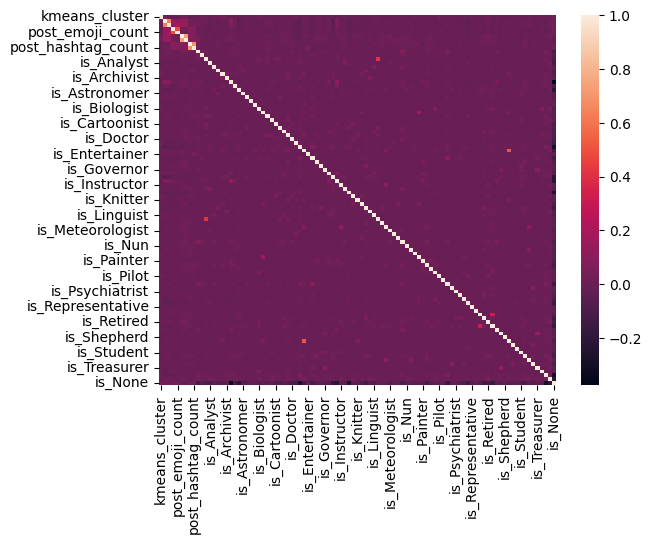

In [ ]:
sns.heatmap(final_df.select_dtypes(int).corr())

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [8]:
rf_classifier = RandomForestClassifier(n_estimators=2000, random_state=42)
rf_classifier.fit(X_train, y_train)
y_hat = rf_classifier.predict(X_test)

classification_report(y_test, y_hat, output_dict=True)

{'0': {'precision': 0.9873444873444873,
  'recall': 0.9991317560234426,
  'f1-score': 0.9932031502858992,
  'support': 4607.0},
 '1': {'precision': 0.2,
  'recall': 0.016666666666666666,
  'f1-score': 0.03076923076923077,
  'support': 60.0},
 'accuracy': 0.9865009642168416,
 'macro avg': {'precision': 0.5936722436722437,
  'recall': 0.5078992113450547,
  'f1-score': 0.511986190527565,
  'support': 4667.0},
 'weighted avg': {'precision': 0.977222209812739,
  'recall': 0.9865009642168416,
  'f1-score': 0.98082988369687,
  'support': 4667.0}}

In [9]:
accuracy_score(y_hat, y_test)

0.9865009642168416

In [10]:
precision_score(y_hat, y_test)

0.016666666666666666

In [11]:

recall_score(y_hat, y_test)

0.2

In [12]:
f1_score(y_hat, y_test)

0.03076923076923077

In [13]:
lr_classifier = LogisticRegression(max_iter=2000)
lr_classifier.fit(X_train, y_train)
y_hat = lr_classifier.predict(X_test)

classification_report(y_test, y_hat, output_dict=True)

/Users/prithaj/.local/share/virtualenvs/bsky_analysis-ipmW1Tub/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'0': {'precision': 0.9871410201457351,
  'recall': 0.9997829390058607,
  'f1-score': 0.9934217621050361,
  'support': 4607.0},
 '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 60.0},
 'accuracy': 0.9869295050353546,
 'macro avg': {'precision': 0.49357051007286756,
  'recall': 0.49989146950293034,
  'f1-score': 0.49671088105251804,
  'support': 4667.0},
 'weighted avg': {'precision': 0.9744501135229059,
  'recall': 0.9869295050353546,
  'f1-score': 0.9806501088532037,
  'support': 4667.0}}